To do:
- singnal estension
- weekly psf
- same analysis from wavelet filter
- adjust load and psf size (date on x axis)

In [2]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from analysis import *

In [3]:
data = pd.read_csv("Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour
Electric.columns

Index(['Date', 'Seconds', 'Load', 'Day', 'Minutes', 'Hour'], dtype='object')

In [4]:
# Week
signal_reconstr = fourierExtrapolation(Electric.Load.values, int(96*7), n_harm=10)

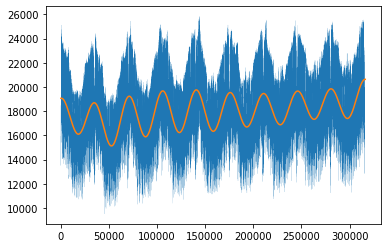

In [5]:
plt.plot(Electric.Load.values, lw=0.1)
plt.plot(signal_reconstr)

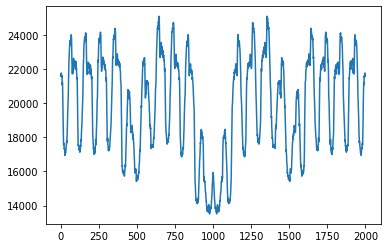

In [6]:
plt.plot(np.concatenate([Electric.Load.values[:1000][::-1], Electric.Load.values[:1000]]))
#plt.xlim(900,1000)

In [7]:
# prima di fare le analisi simili a quelle di gioacchino bisogna estendere 
# il segnale in modo tale da eliminare gli effetti sui bordi dati dalla
# convoluzione.

In [57]:
def psf_forecasting(df, feature, wavelet='sym4', thr=0.04, plot=False):
    
    if feature == 'load_denoised':    
        df[feature] = wavelet_filter(df['Load'].to_numpy(), 
                                     wavelet=wavelet,
                                     threshold=thr)
    else:
        pass

    f = {feature: ['mean', q1, q2]}
    psfs = df.groupby(['Hour',
                       'Minutes']).agg(f).reset_index()[feature].to_numpy()

    psf = psfs[:, 0]
    psf_q1 = psfs[:, 1]
    psf_q2 = psfs[:, 2]

    load = df[feature].to_numpy()
    deconv_psf = deconvolution(load, psf)
    deconv_psfq1 = deconvolution(load, psf_q1)
    deconv_psfq2 = deconvolution(load, psf_q2)

    load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
    load_q1 = np.convolve(deconv_psfq1, psf_q1, 'valid')[:-96]
    load_q2 = np.convolve(deconv_psfq2, psf_q2, 'valid')[:-96]

    if plot:
        psf_forecast_plot(Electric, load_psf, load_q1, load_q2, load)
    else:
        pass

    return load_psf

#def decorator_psf(func):
#    return psf_forecasting

#@decorator_psf
def psf_forecast_plot(df, load_psf, load_q1, load_q2, load):
    t = df.Date.iloc[:-191]

    plt.figure(figsize=(12, 9))
    plt.plot(t, load_psf, 'b', lw=0.1, label='psf')
    plt.fill_between(x=t, y1=load_q1, y2=load_q2, color='b', alpha=0.3,
                    label='psf quantiles (ci=95%)')
    plt.plot(t, load[:-191], 'r', lw=0.1, alpha=0.5, label='data')
    plt.grid()
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Load (MWh)')

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tight_layout()
    leg = plt.legend()

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh.set_linewidth(1)

In [59]:
def find_optimal_threshold(df, forecasting_func, thresholds,
                           wavelets=['coif5', 'sym4', 'sym5']):
    n = len(thresholds)
    m = len(wavelets)
    mses = np.zeros((n, m))
    forecast_noise = forecasting_func(df, 'Load')
    mse_noise = mse(df.Load.to_numpy()[:-191], forecast_noise)

    for j, wavelet in enumerate(wavelets):
        for i, thr in enumerate(thresholds):
            print(i, thr)
            forecast_denoised = forecasting_func(df, 'load_denoised',
                                                 wavelet, thr)
            mse_denoised = mse(df.Load.to_numpy()[:-191], forecast_denoised)
            mses[i, j] = mse_denoised
    
    return mse_noise, mses


In [ ]:
thresholds = np.arange(0.1, 1.0, 0.1)
n = len(thresholds)
mse_noise, mses = find_optimal_threshold(Electric, psf_forecasting, 
                                         thresholds)

In [96]:
x, y = np.where(mses == np.min(mses))
thresholds[x], mses[x, y]

(array([0.4]), array([5927693.52319997]))

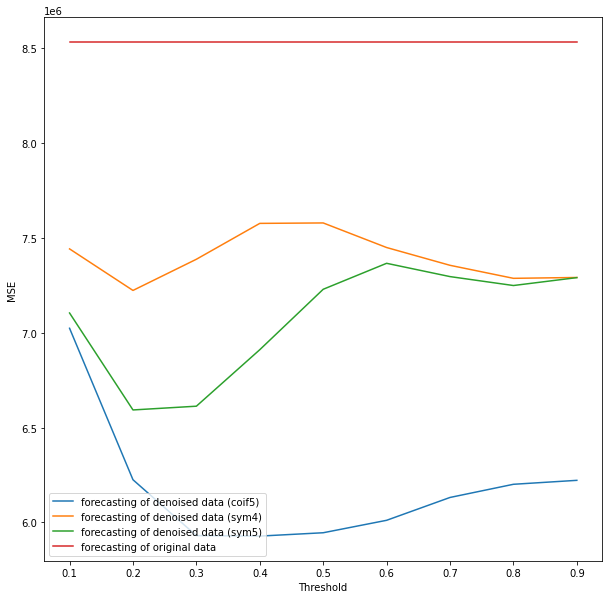

In [76]:
plt.figure(figsize=(10, 10))
wavelets = ['coif5', 'sym4', 'sym5']
for i, wavelet in enumerate(wavelets):
    plt.plot(thresholds, mses[:, i], label=f'forecasting of denoised data ({wavelet})')
plt.plot(thresholds, [mse_noise]*n, label='forecasting of original data')
#plt.plot(thresholds[np.argmin(mses)], mses.min(), 'xr') #, label='Minimum mse')
plt.xlabel('Threshold')
plt.ylabel('MSE')
plt.legend()
#thresholds[np.argmin(mses)], mses.min()

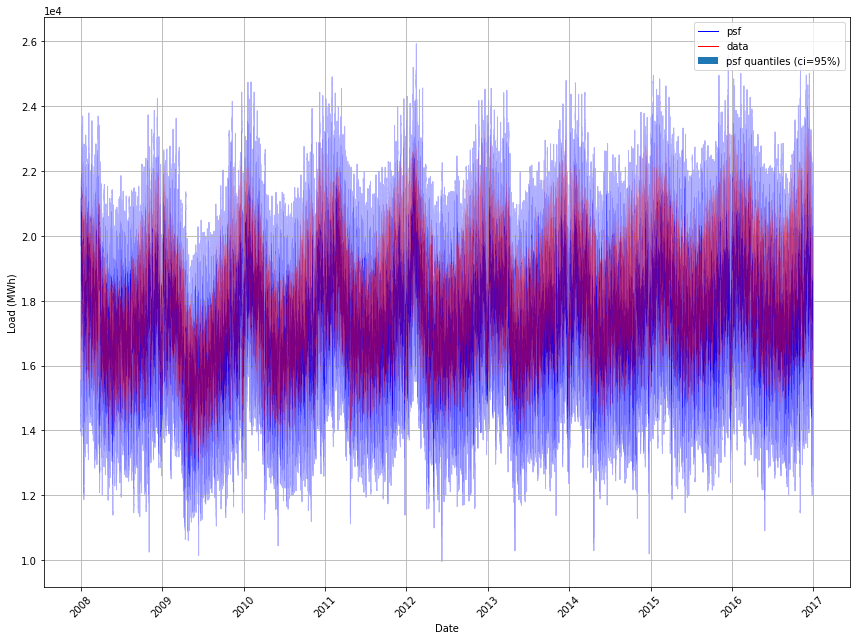

In [53]:
psf_forecasting(Electric, 'load_denoised', 0.19, True);

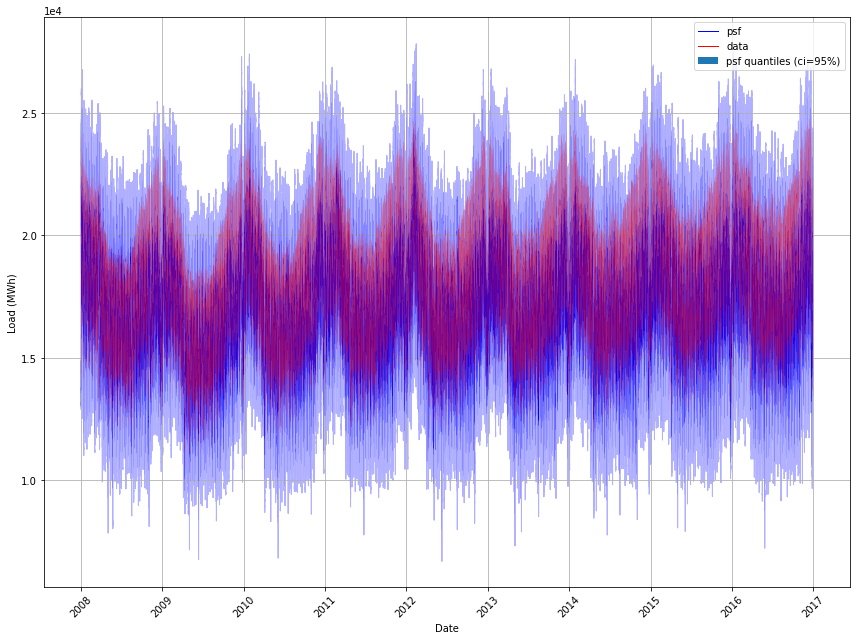

In [56]:
psf_forecasting(Electric, 'load_denoised', 0.04, True);